# Audio regression using resnet

In [3]:
from src.audio_dataset import AudioRegressionDataset
from src.train import train, lr_decay
from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd
import torch
from torchvision.models import resnet34, resnet50, resnet101
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [4]:
dim = "height" #width / height / duration ...

In [6]:
path = str(Path.cwd())
train_path = path + "/data/train/"
valid_path = path + "/data/valid/"

train_data = pd.read_csv(train_path + "train.csv")#[:200]
valid_data = pd.read_csv(valid_path + "valid.csv")#[:40]

train_data["class"] = train_data[dim]
valid_data["class"] = valid_data[dim]

train_data_set = AudioRegressionDataset(train_path, train_data, in_featr='filename', out_featr='class')
valid_data_set = AudioRegressionDataset(valid_path, valid_data, in_featr='filename', out_featr='class')

train_loader = DataLoader(train_data_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data_set, batch_size=16, shuffle=True)

100%|██████████| 40/40 [00:00<00:00, 42.14it/s]


## Set up ResNet model

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')     
resnet_model = resnet34(weights="DEFAULT")
resnet_model.fc = nn.Sequential(nn.Linear(512,2048),
                                nn.Linear(2048,2048),
                                nn.Linear(2048, 1024),
                                nn.Linear(1024, 1024),
                                nn.Linear(1024,1))  # (512, 50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

## Train Model

In [9]:
learning_rate = 1e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50

train_losses = []
valid_losses = []
loss = nn.SmoothL1Loss()

train(resnet_model, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, device, lr_decay, loss, "regression")

  2%|▏         | 1/50 [00:04<03:50,  4.70s/it]

Epoch - 1 Train-Loss : 155.46872006929837
Epoch - 1 Valid-Loss : 65.20222473144531 Valid-MAE : 62.81629180908203


  4%|▍         | 2/50 [00:06<02:09,  2.70s/it]

Epoch - 2 Train-Loss : 61.18241207416241
Epoch - 2 Valid-Loss : 72.35399119059245 Valid-MAE : 72.84883117675781


  6%|▌         | 3/50 [00:07<01:37,  2.07s/it]

Epoch - 3 Train-Loss : 41.9829227740948
Epoch - 3 Valid-Loss : 53.802407582600914 Valid-MAE : 52.41926193237305


  8%|▊         | 4/50 [00:08<01:21,  1.77s/it]

Epoch - 4 Train-Loss : 34.22810437129094
Epoch - 4 Valid-Loss : 42.3522097269694 Valid-MAE : 44.13814926147461


 10%|█         | 5/50 [00:09<01:12,  1.60s/it]

Epoch - 5 Train-Loss : 30.153838964609
Epoch - 5 Valid-Loss : 38.87271626790365 Valid-MAE : 41.46733474731445


 12%|█▏        | 6/50 [00:11<01:06,  1.50s/it]

Epoch - 6 Train-Loss : 28.72448128920335
Epoch - 6 Valid-Loss : 48.71967061360677 Valid-MAE : 51.436744689941406


 14%|█▍        | 7/50 [00:12<01:01,  1.44s/it]

Epoch - 7 Train-Loss : 34.11935703571026
Epoch - 7 Valid-Loss : 45.18487421671549 Valid-MAE : 47.250526428222656


 14%|█▍        | 7/50 [00:13<01:24,  1.97s/it]

Epoch - 8 Train-Loss : 30.239922743577225


KeyboardInterrupt: 

## Plot training loss

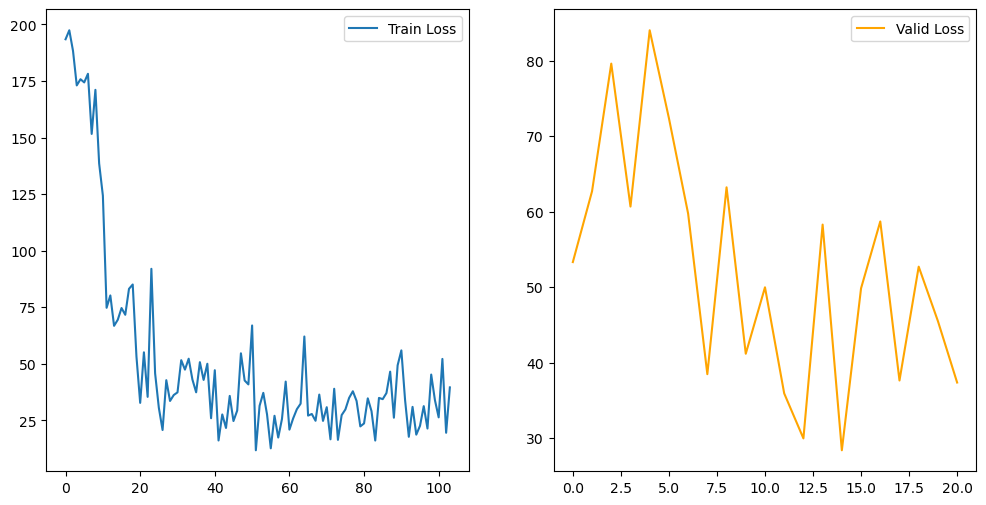

In [10]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
plt.show()